# Nighttime Lights and GDP Analysis

## Data

1. **Nighttime Lights Data**:
   - **Source**: NOAA's VIIRS (Visible Infrared Imaging Radiometer Suite) Collection 2 products.
   - **Description**: This dataset provides daily nighttime lights intensity data, which is used to analyze economic activity and its correlation with GDP figures.
   - **Spatial Resolution**: 500 meters.
   - **Temporal Coverage**: Available daily from 2012 to 2025.

2. **National GDP Data**:
   - **Source**: World Bank World Development Indicators (WDI).
   - **Description**: This dataset provides annual national GDP figures for Myanmar, which are used to analyze economic trends in relation to nighttime lights data.
   - **Temporal Coverage**: Available annually from 1961 to 2024.

3. **Manufacturing GDP Data**:
   - **Source**: Provided by the Myanmar team.
   - **Description**: This dataset contains quarterly manufacturing GDP figures for Myanmar, which are used to assess the relationship between manufacturing activity and nighttime lights intensity.
   - **Temporal Coverage**: Available quarterly from 2015 to 2024.

4. **Administrative Boundaries**:
   - **Source**: MIMU (Myanmar Information Management Unit)
   - **Description**: This dataset provides the administrative boundaries for Myanmar at various levels (national, state/region, district, township). It is used for spatial aggregation and analysis of crop productivity and economic data.
   - **Spatial Resolution**: Varies by administrative level.

## Assumptions and Methodological Notes

This analysis is based on the following assumptions and methodological considerations:

### Temporal Definitions and Aggregations

1. **Fiscal Year Definition**: The first quarter (Q1) of each fiscal year starts in April and ends in March of the following year. This aligns with Myanmar's fiscal calendar.

2. **Quarterly Aggregations**: Monthly data are aggregated into quarters (Q1: April-June, Q2: July-September, Q3: October-December, Q4: January-March).

### Methodological Assumptions

1. **Spatial Aggregation**: Manufacturing GDP is available quarterly from 2015 to 2024. However, regional manufacturing GDP are assumed to be identical to the regional industry GDP data available for the 2015-2016 financial year. Additionally, the manufacturing GDP at administrative level 1 are assumed to remain constant across all years in the analysis period.

## Library

In [1]:
from pathlib import Path

import plotnine as p9
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
import pandas as pd
import numpy as np
import geopandas as gpd

import warnings

warnings.filterwarnings("ignore")

## Functions

In [2]:
def clean_names(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names."""
    df = df.rename(columns=lambda col: col.strip().lower().replace(" ", "_"))
    return df


def find_project_root(marker_file: str = "pyproject.toml") -> Path:
    for parent in Path().cwd().parents:
        if (parent / marker_file).exists():
            return parent
    raise FileNotFoundError(f"No project root found with marker file: {marker_file}")

In [3]:
PROJECT_ROOT = find_project_root()
DATA_PATH = PROJECT_ROOT / "data"
BOUNDARIES_PATH = DATA_PATH / "Shapefiles"

In [4]:
adm1 = gpd.read_file(
    BOUNDARIES_PATH / "mmr_polbnda2_adm1_250k_mimu" / "mmr_polbnda2_adm1_250k_mimu.shp"
)

adm4 = gpd.read_file(BOUNDARIES_PATH / "adm4.geojson")

sez_locations_raw = pd.read_csv(DATA_PATH / "NTL" / "sez_locations.csv").pipe(
    lambda df: gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.lon, df.lat, crs="EPSG:4326")
    )
)

sez_adm1_count = (
    adm1.sjoin(sez_locations_raw, predicate="contains", how="inner")
    .groupby("ST")
    .agg(sez_count=("Name", "size"))
    .reset_index()
    .pipe(clean_names)
    .rename(columns={"st": "adm1_name"})
)

In [5]:
def process_gdp(filename: str) -> pd.DataFrame:
    return (
        (
            pd.read_csv(DATA_PATH / "GDP" / filename, skiprows=4)
            .pipe(clean_names)
            .loc[lambda df: df["country_name"] == "Myanmar"]
        )
        .melt(
            id_vars=[
                "country_name",
                "country_code",
                "indicator_name",
                "indicator_code",
            ],
            var_name="year",
            value_name="gdp",
        )
        .dropna(subset=["gdp"])
        .assign(
            date=lambda df: pd.to_datetime(df["year"], format="%Y"),
            gdp=lambda df: df["gdp"] / 1_000_000,  # Convert to millions
        )
        .set_index("date")
        .filter(["gdp"])
    )


gdp_lcu = process_gdp("GDP All Countries.csv").rename(
    columns={"gdp": "gdp_constant_lcu"}
)
gdp_usd = process_gdp("GDP Current USD All Countries.csv").rename(
    columns={"gdp": "gdp_current_usd"}
)
gdp_overall = gdp_lcu.join(gdp_usd)

In [6]:
gdp_quarterly_raw = pd.read_excel(
    DATA_PATH / "GDP" / "Quarterly GDP per Sector.xlsx",
    sheet_name=1,
    skiprows=1,
    skipfooter=1,
)
gdp_adm1_raw = pd.read_excel(
    DATA_PATH / "GDP" / "Quarterly GDP per Sector.xlsx", sheet_name=0, skiprows=1
).rename(columns={"Unnamed: 0": "ADM1_NAME"})

In [7]:
ntl_annual_adm0 = (
    pd.read_csv(DATA_PATH / "NTL" / "ntl_annual_adm0_collection2.csv")
    .drop(columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"])
    .assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .sort_index()
)

ntl_annual_adm1 = (
    pd.read_csv(DATA_PATH / "NTL" / "ntl_annual_adm1_collection2.csv")
    .drop(columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"])
    .assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .sort_index()
)

ntl_monthly_adm0_raw = pd.read_csv(
    DATA_PATH / "NTL" / "ntl_monthly_adm0_collection2.csv"
).drop(columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"])
ntl_monthly_adm1_raw = pd.read_csv(
    DATA_PATH / "NTL" / "ntl_monthly_adm1_collection2.csv"
).drop(columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"])
ntl_monthly_sez_adm1_raw = pd.read_csv(
    DATA_PATH / "NTL" / "ntl_ind_adm1_monthly_collection2.csv"
).drop(columns=["Unnamed: 0"])

ntl_monthly_adm4_raw = pd.read_parquet(
    DATA_PATH / "NTL" / "ntl_monthly_adm4_collection2.parquet"
)


ntl_quarterly_adm0 = (
    ntl_monthly_adm0_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby(pd.Grouper(freq="QS"))
    .agg({"ntl_sum": "sum"})
    .assign(
        ntl_sum_lag_1=lambda df: df["ntl_sum"].shift(1),
        ntl_sum_lag_2=lambda df: df["ntl_sum"].shift(2),
        ntl_sum_lag_3=lambda df: df["ntl_sum"].shift(3),
    )
)

ntl_quarterly_adm1 = (
    ntl_monthly_adm1_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .rename(columns={"adm1_en": "adm1_name"})
    .groupby(["adm1_name", pd.Grouper(freq="QS")])
    .agg({"ntl_sum": "sum"})
    .reset_index()
    .groupby("adm1_name")
    .apply(
        lambda df: df.assign(
            ntl_sum_lag_1=df["ntl_sum"].shift(1),
            ntl_sum_lag_2=df["ntl_sum"].shift(2),
            ntl_sum_lag_3=df["ntl_sum"].shift(3),
        )
    )
    .reset_index(drop=True)
    .set_index(["adm1_name", "date"])
)

ntl_annual_adm0_sez = (
    ntl_monthly_sez_adm1_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby(pd.Grouper(freq="YS"))
    .agg({"ntl_sum": "sum"})
    .reset_index()
    .set_index("date")
)

ntl_quarterly_adm1_sez = (
    ntl_monthly_sez_adm1_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .rename(columns={"adm1_en": "adm1_name"})
    .groupby(["adm1_name", pd.Grouper(freq="QS")])
    .agg({"ntl_sum": "sum"})
    .reset_index()
    .groupby("adm1_name")
    .apply(
        lambda df: df.assign(
            ntl_sum_lag_1=df["ntl_sum"].shift(1),
            ntl_sum_lag_2=df["ntl_sum"].shift(2),
            ntl_sum_lag_3=df["ntl_sum"].shift(3),
        )
    )
    .reset_index(drop=True)
    .set_index(["adm1_name", "date"])
)

In [8]:
gdp_adm1_name_map = {
    "Ayeyarwaddy Region": "Ayeyarwady",
    "Bago Region": "Bago",
    "Chin State": "Chin",
    "Kachin State": "Kachin",
    "Kayah State": "Kayah",
    "Kayin State": "Kayin",
    "Magwe Region": "Magway",
    "Mandalay Region": "Mandalay",
    "Mon State": "Mon",
    "Nay Pyi Taw Council": "Nay Pyi Taw",
    "Rakhine State": "Rakhine",
    "Sagaing Region": "Sagaing",
    "Shan State": "Shan",
    "Tanintharyi Region": "Tanintharyi",
    "Yangon Region": "Yangon",
}


def preprocess_bago_and_shan(df: pd.DataFrame) -> pd.DataFrame:
    """Split the values of Bago into two equal parts and Shan into three equal parts."""
    df_bago = df.query("adm1_name == 'Bago'").copy()
    df_bago_new = pd.DataFrame(
        {
            "adm1_name": ["Bago (East)", "Bago (West)"],
            "agriculture": [df_bago["agriculture"].values[0] / 2] * 2,
            "industry": [df_bago["industry"].values[0] / 2] * 2,
            "services": [df_bago["services"].values[0] / 2] * 2,
        }
    )

    df_shan = df.query("adm1_name == 'Shan'").copy()
    df_shan_new = pd.DataFrame(
        {
            "adm1_name": ["Shan (South)", "Shan (East)", "Shan (North)"],
            "agriculture": [df_shan["agriculture"].values[0] / 3] * 3,
            "industry": [df_shan["industry"].values[0] / 3] * 3,
            "services": [df_shan["services"].values[0] / 3] * 3,
        }
    )

    df_rest = df.query("adm1_name not in ['Bago', 'Shan']").copy()

    return pd.concat([df_rest, df_bago_new, df_shan_new], ignore_index=True)


gdp_adm1 = (
    gdp_adm1_raw.pipe(clean_names)
    .assign(adm1_name=lambda df: df["adm1_name"].map(gdp_adm1_name_map))
    .pipe(preprocess_bago_and_shan)
    .assign(industry_pct=lambda df: df["industry"] / df["industry"].sum())
)

gdp_quarterly = (
    gdp_quarterly_raw.pipe(clean_names)
    .melt(
        id_vars=["quarter", "sub_group", "economic_activity"],
        var_name="year",
        value_name="gdp",
    )
    .assign(
        quarter_clean=lambda df: df["quarter"].str.strip(),
        year_first=lambda df: df["year"].str.split("-").str[0].str.strip(),
        year_last=lambda df: df["year"].str.split("-").str[1].str.strip(),
        # Map fiscal quarters to calendar quarters and years
        calendar_quarter=lambda df: df["quarter_clean"].map(
            {"Q1": "Q2", "Q2": "Q3", "Q3": "Q4", "Q4": "Q1"}
        ),
        year_selected=lambda df: df.apply(
            lambda row: row["year_last"]
            if row["quarter_clean"] == "Q4"
            else row["year_first"],
            axis=1,
        ),
        date=lambda df: pd.to_datetime(df["year_selected"] + df["calendar_quarter"]),
        sub_group=lambda df: df["sub_group"].str.strip(),
        economic_activity=lambda df: df["economic_activity"].str.strip(),
    )
    .query('sub_group == "Industry" and economic_activity == "Manufacturing"')
    .set_index("date")
    .sort_index()
    .groupby(["sub_group", "economic_activity", pd.Grouper(freq="QS")])
    .agg({"gdp": "sum"})
    .reset_index()
    .sort_values(["sub_group", "date"])
    .assign(
        gdp_lag_1=lambda df: df["gdp"].shift(1),
        gdp_lag_2=lambda df: df["gdp"].shift(2),
    )
)

gdp_quarterly_adm1 = (
    pd.DataFrame(
        [
            (region, period)
            for region in gdp_adm1["adm1_name"].unique()
            for period in gdp_quarterly["date"].unique()
        ],
        columns=["adm1_name", "date"],
    )
    .merge(gdp_adm1.filter(["adm1_name", "industry_pct"]), on="adm1_name", how="left")
    .merge(gdp_quarterly, on="date", how="left")
    .rename(
        columns={
            "gdp": "gdp_total",
            "gdp_lag_1": "gdp_lag_1_total",
            "gdp_lag_2": "gdp_lag_2_total",
        }
    )
    .assign(
        gdp=lambda df: df["gdp_total"] * df["industry_pct"],
        gdp_lag_1=lambda df: df["gdp_lag_1_total"] * df["industry_pct"],
        gdp_lag_2=lambda df: df["gdp_lag_2_total"] * df["industry_pct"],
    )
    .set_index(["adm1_name", "date"])
    .filter(["gdp", "gdp_lag_1", "gdp_lag_2"])
)

## Analysis

### Overall GDP vs Nighttime Lights

The chart below shows a positive correlation between annual nighttime lights and overall GDP (constant LCU) at the national level from 2012 to 2024. The relationship appears nearly linear, suggesting that nighttime lights intensity can serve as a reliable proxy for economic activity measured by GDP.

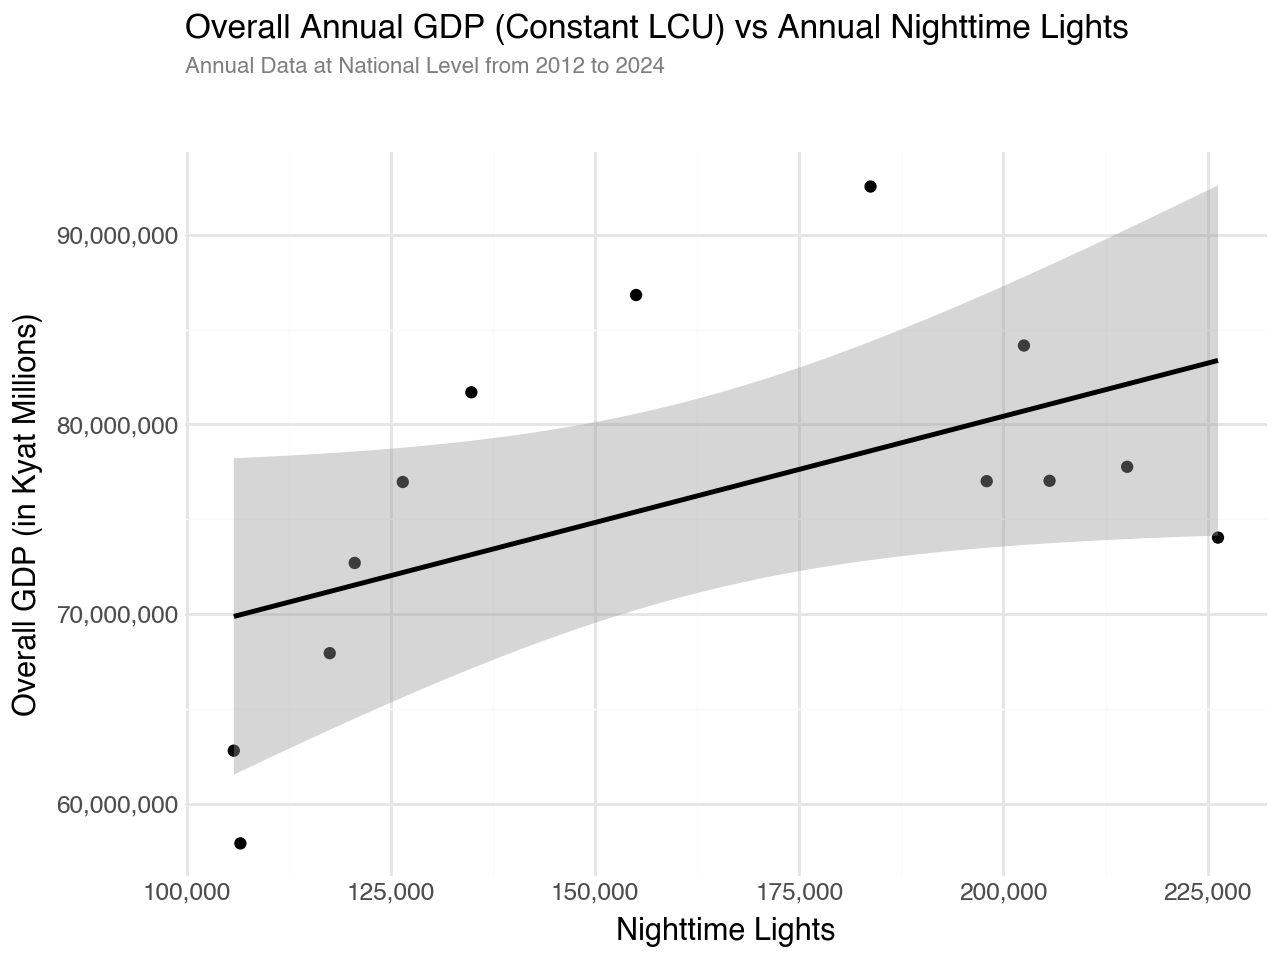

In [9]:
# Overall GDP (constant LCU) vs Nighttime Lights
(
    gdp_overall.join(ntl_annual_adm0, how="inner").pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp_constant_lcu")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_x_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="Overall Annual GDP (Constant LCU) vs Annual Nighttime Lights",
        subtitle="Annual Data at National Level from 2012 to 2024",
        x="Nighttime Lights",
        y="Overall GDP (in Kyat Millions)",
    )
    + p9.theme_minimal()
    + p9.theme(
        plot_title=p9.element_text(size=12, weight="bold"),
        plot_subtitle=p9.element_text(size=8, color="grey", margin={"b": 20}),
    )
)

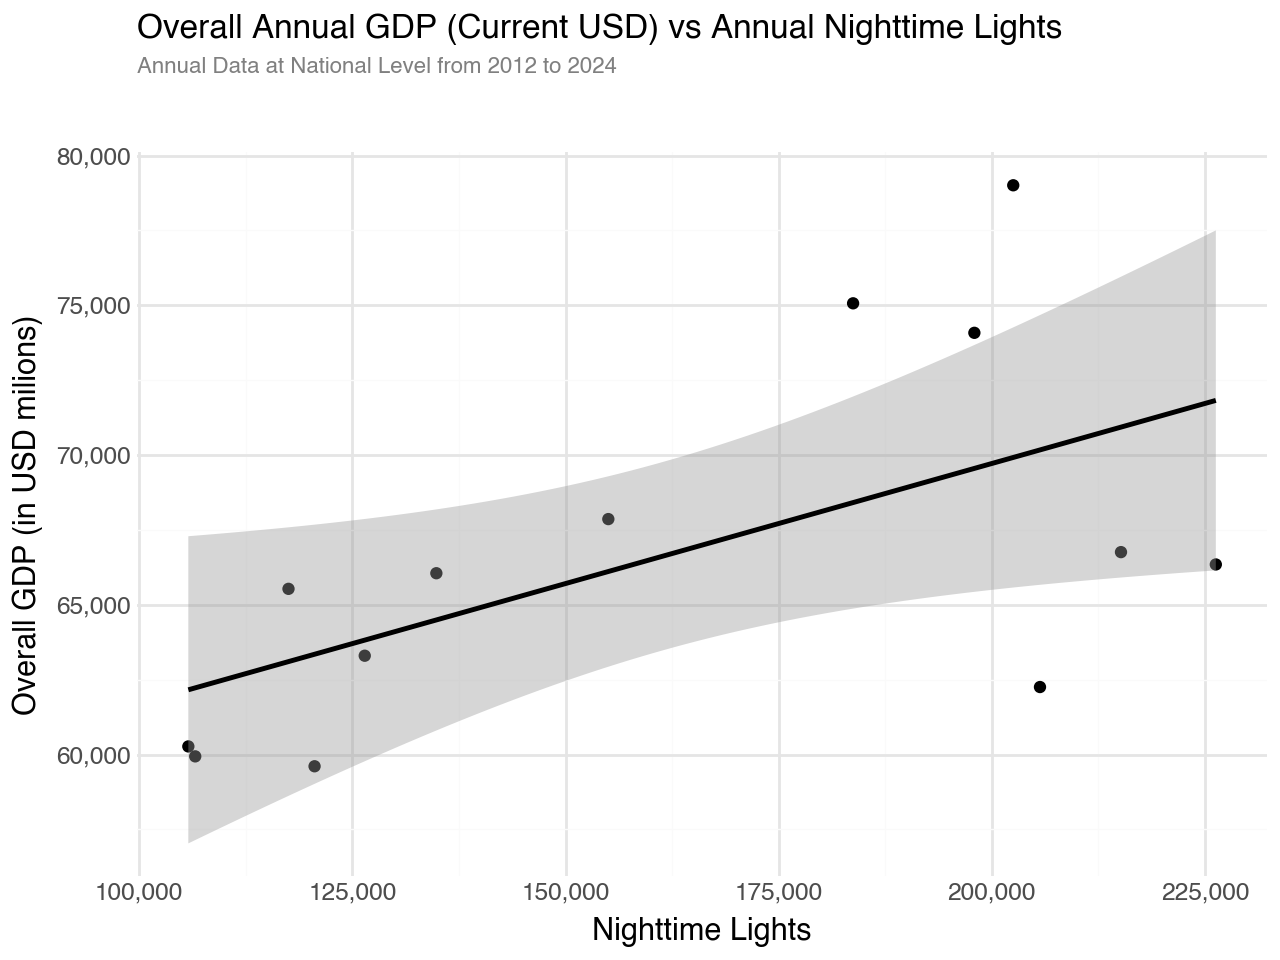

In [10]:
# Overall GDP (current USD) vs Nighttime Lights
(
    gdp_overall.join(ntl_annual_adm0, how="inner").pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp_current_usd")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_x_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="Overall Annual GDP (Current USD) vs Annual Nighttime Lights",
        subtitle="Annual Data at National Level from 2012 to 2024",
        x="Nighttime Lights",
        y="Overall GDP (in USD milions)",
    )
    + p9.theme_minimal()
    + p9.theme(
        plot_title=p9.element_text(size=12, weight="bold"),
        plot_subtitle=p9.element_text(size=8, color="grey", margin={"b": 20}),
    )
)

## Nighttime Lights in Industrial Zones vs GDP

When focusing specifically on nighttime lights from industrial zones (SEZ areas), we still observe a positive correlation with overall national GDP. This suggests that economic activity in industrial zones, as captured by nighttime lights, is closely linked to broader national economic performance.

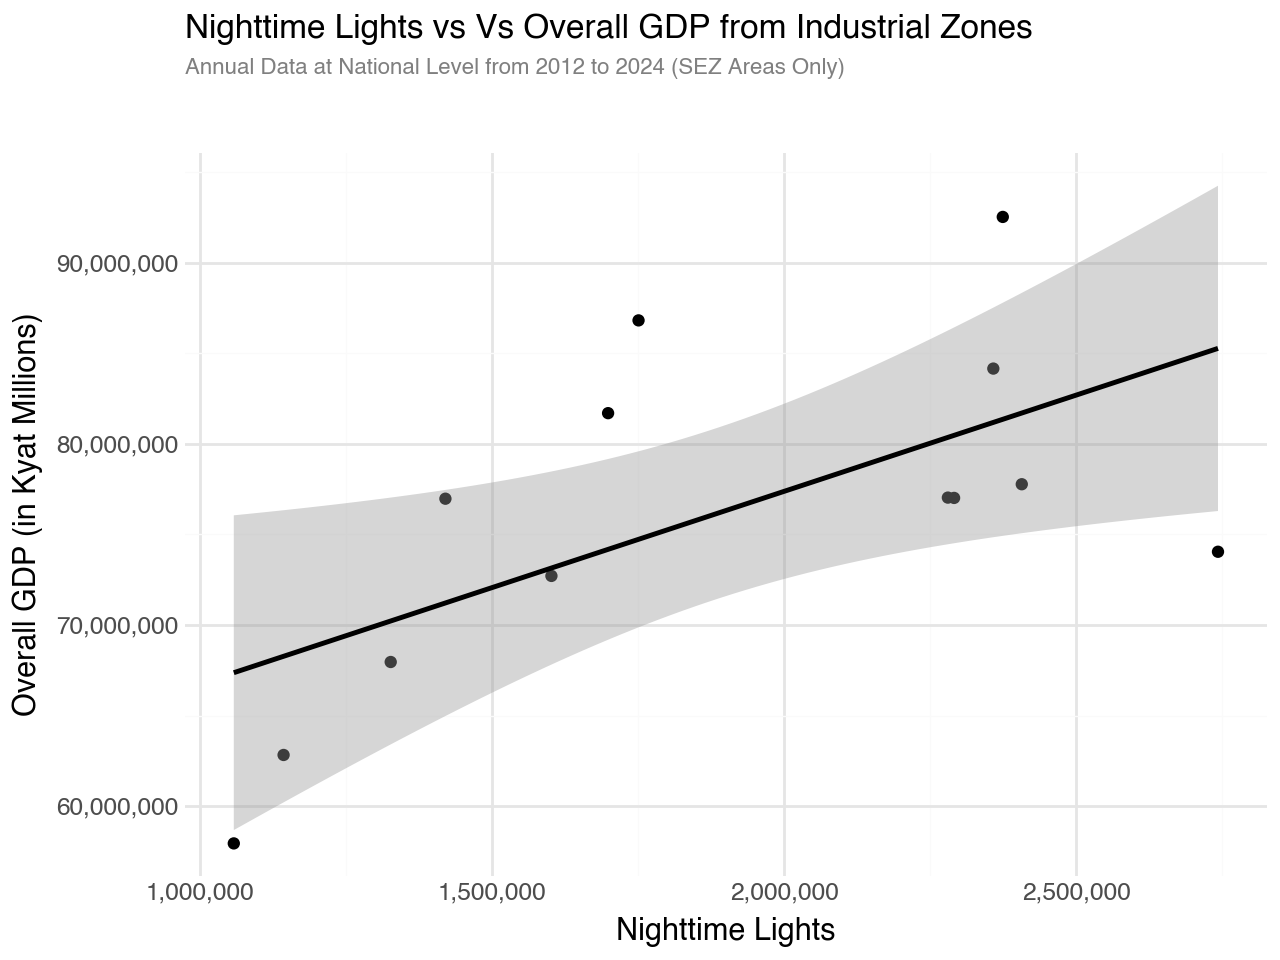

In [11]:
# Chart 1: Overall Annual GDP vs Nighttime Lights from Industrial Zones
# Chart 2: Manufacturing Annual GDP vs Nighttime Lights from Industrial Zones
(
    gdp_overall.join(ntl_annual_adm0_sez, how="inner").pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp_constant_lcu")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_x_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="Nighttime Lights vs Vs Overall GDP from Industrial Zones",
        subtitle="Annual Data at National Level from 2012 to 2024 (SEZ Areas Only)",
        x="Nighttime Lights",
        y="Overall GDP (in Kyat Millions)",
    )
    + p9.theme_minimal()
    + p9.theme(
        plot_title=p9.element_text(size=12, weight="bold"),
        plot_subtitle=p9.element_text(size=8, color="grey", margin={"b": 20}),
    )
)

The relationship between nighttime lights in industrial zones and manufacturing GDP is particularly strong, which makes intuitive sense as manufacturing activities typically occur in industrial areas. The positive correlation indicates that nighttime lights from SEZ areas can serve as a indicator for manufacturing sector performance.

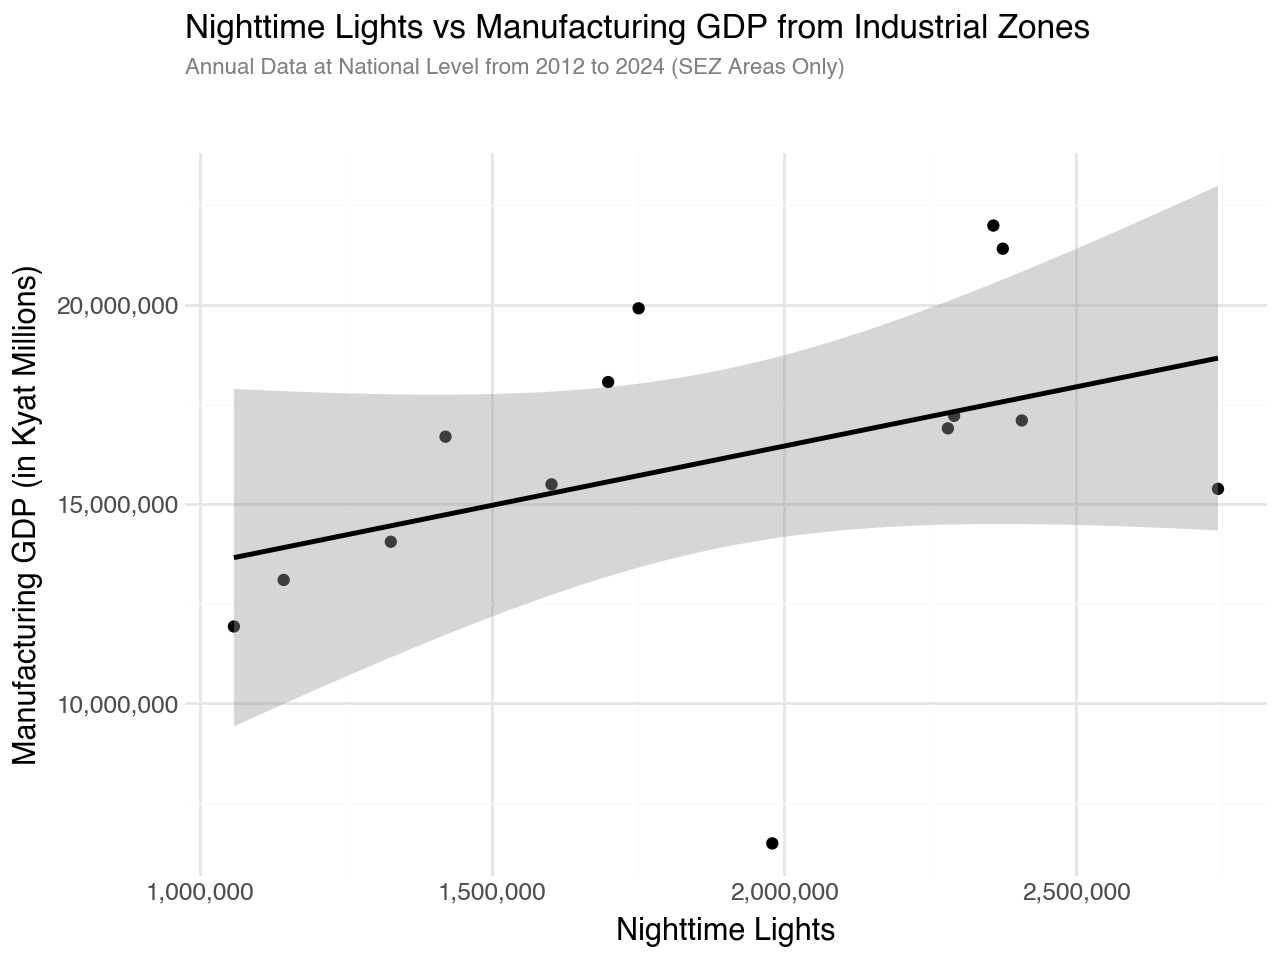

In [12]:
(
    gdp_quarterly.set_index("date")
    .groupby(pd.Grouper(freq="YS"))
    .agg({"gdp": "sum"})
    .join(ntl_annual_adm0_sez, how="inner")
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_x_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="Nighttime Lights vs Manufacturing GDP from Industrial Zones",
        subtitle="Annual Data at National Level from 2012 to 2024 (SEZ Areas Only)",
        x="Nighttime Lights",
        y="Manufacturing GDP (in Kyat Millions)",
    )
    + p9.theme_minimal()
    + p9.theme(
        plot_title=p9.element_text(size=12, weight="bold"),
        plot_subtitle=p9.element_text(size=8, color="grey", margin={"b": 20}),
    )
)

The table below shows the regression results of overall GDP against nighttime lights at both the national level and for SEZ areas only. The regression results show statistically significant positive relationships in both models. At the national level, a 1% increase in nighttime lights is associated with approximately 0.276% increase in GDP. When focusing on SEZ areas only, the coefficient is similar at 0.290%.

In [13]:
gdp_overall_ntl = gdp_overall.join(ntl_annual_adm0, how="inner").assign(
    gdp_constant_lcu_log=lambda df: np.log(df["gdp_constant_lcu"]),
    ntl_sum_log=lambda df: np.log(df["ntl_sum"]),
)

gdp_overall_ntl_sez = gdp_overall.join(ntl_annual_adm0_sez, how="inner").assign(
    gdp_constant_lcu_log=lambda df: np.log(df["gdp_constant_lcu"]),
    ntl_sum_log=lambda df: np.log(df["ntl_sum"]),
)

mod_1 = smf.ols("gdp_constant_lcu_log ~ ntl_sum_log", data=gdp_overall_ntl).fit()
mod_2 = smf.ols("gdp_constant_lcu_log ~ ntl_sum_log", data=gdp_overall_ntl_sez).fit()

models = Stargazer([mod_1, mod_2])
models.custom_columns(["National Level", "SEZ Areas Only"], [1, 1])
models

## Quarterly GDP vs Quarterly Nighttime Lights

### Manufacturing GDP vs Nighttime Lights

The chart below shows the relationship between quarterly manufacturing GDP and nighttime lights across current quarter and lagged values.

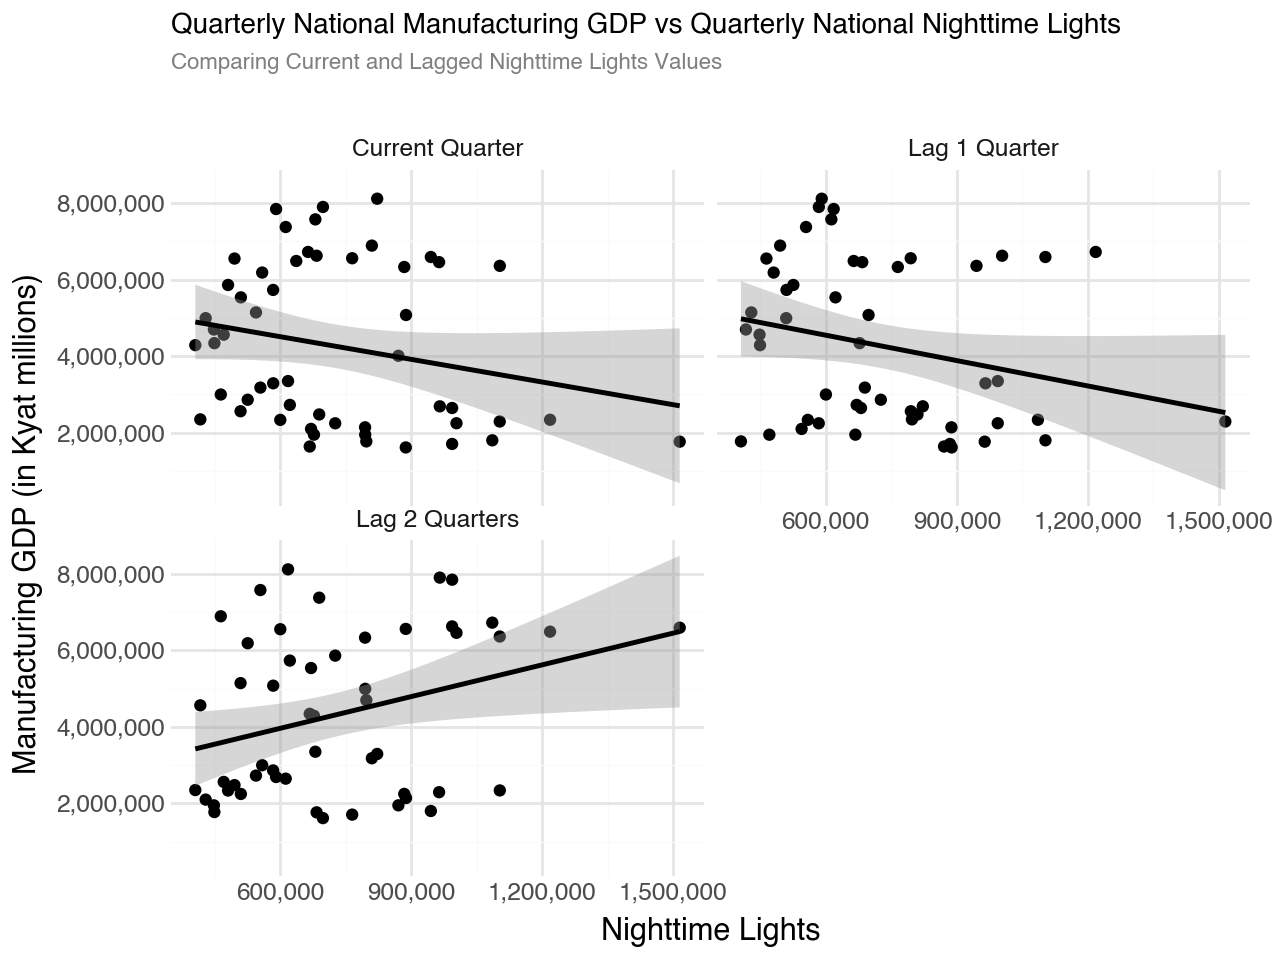

In [14]:
# Chart 1: Quarterly Manufacturing GDP vs Quarterly NTL from Industrial Zones
(
    gdp_quarterly.set_index("date")
    .join(ntl_quarterly_adm0, how="inner")
    .reset_index()
    .melt(
        id_vars=["date", "gdp"],
        value_vars=["ntl_sum", "ntl_sum_lag_1", "ntl_sum_lag_2"],
    )
    .assign(
        variable=lambda df: df["variable"].map(
            {
                "ntl_sum": "Current Quarter",
                "ntl_sum_lag_1": "Lag 1 Quarter",
                "ntl_sum_lag_2": "Lag 2 Quarters",
            }
        )
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="value", y="gdp")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("~variable", ncol=2)
    + p9.scale_x_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="Quarterly National Manufacturing GDP vs Quarterly National Nighttime Lights",
        subtitle="Comparing Current and Lagged Nighttime Lights Values",
        x="Nighttime Lights",
        y="Manufacturing GDP (in Kyat millions)",
    )
    + p9.theme_minimal()
    + p9.theme(
        plot_title=p9.element_text(size=10, weight="bold"),
        plot_subtitle=p9.element_text(size=8, color="grey", margin={"b": 20}),
    )
)

The following table below presents the regression results of manufacturing GDP against nighttime lights on quarterly data at the national level.

In [15]:
gdp_quarterly_adm0 = (
    gdp_quarterly.set_index("date")
    .join(ntl_quarterly_adm0, how="inner")
    .assign(
        ntl_sum_lag_1=lambda df: df["ntl_sum"].shift(1),
        ntl_sum_lag_2=lambda df: df["ntl_sum"].shift(2),
        gdp_log=lambda df: np.log(df["gdp"]),
        ntl_sum_log=lambda df: np.log(df["ntl_sum"]),
        ntl_sum_lag_1_log=lambda df: np.log(df["ntl_sum_lag_1"]),
        ntl_sum_lag_2_log=lambda df: np.log(df["ntl_sum_lag_2"]),
    )
)

mod_1 = smf.ols("gdp_log ~ ntl_sum_log", data=gdp_quarterly_adm0).fit()
mod_2 = smf.ols("gdp_log ~ ntl_sum_lag_1_log", data=gdp_quarterly_adm0).fit()
mod_3 = smf.ols("gdp_log ~ ntl_sum_lag_2_log", data=gdp_quarterly_adm0).fit()

models = Stargazer([mod_1, mod_2, mod_3])
models.custom_columns(
    [
        "Current",
        "Lag 1 Quarter",
        "Lag 2 Quarters",
    ],
    [1, 1, 1],
)
models.covariate_order(
    [
        "ntl_sum_log",
        "ntl_sum_lag_1_log",
        "ntl_sum_lag_2_log",
    ]
)
models

### Admin Level 1

```{note}
The table below shows the proportion of industry GDP across administrative level 1 regions in Myanmar. This proportion is assumed to be identical to the manufacturing GDP proportion and constant over time for the purpose of estimating administrative level 1 manufacturing GDP.
```

In [16]:
(
    gdp_adm1.filter(["adm1_name", "industry_pct"])
    .sort_values("industry_pct", ascending=False)
    .assign(
        industry_pct=lambda df: df["industry_pct"].apply(
            lambda x: "{:.1f}%".format(x * 100)
        )
    )
    .rename(columns={"industry_pct": "Industry"})
)

,adm1_name,Industry
12,Yangon,35.4%
10,Sagaing,12.8%
6,Mandalay,12.3%
5,Magway,7.9%
0,Ayeyarwady,5.1%
7,Mon,4.1%
14,Bago (West),3.7%
13,Bago (East),3.7%
9,Rakhine,2.6%
11,Tanintharyi,2.0%


### Manufacturing GDP vs Nighttime Lights across Admin Level 1 Regions

In [17]:
ntl_indicators_adm1 = (
    gdp_quarterly_adm1.join(ntl_quarterly_adm1, how="inner")
    .reset_index()
    .merge(sez_adm1_count, on="adm1_name", how="left")
    .sort_values(["adm1_name", "date"])
    .assign(
        gdp_log=lambda df: np.log(df["gdp"]),
        ntl_sum_log=lambda df: np.log(df["ntl_sum"]),
        ntl_sum_lag_1_log=lambda df: np.log(df["ntl_sum_lag_1"]),
        ntl_sum_lag_2_log=lambda df: np.log(df["ntl_sum_lag_2"]),
        ntl_sum_lag_3_log=lambda df: np.log(df["ntl_sum_lag_3"]),
        sez_count=lambda df: df["sez_count"].fillna(0),
        sez_count_log=lambda df: np.log1p(df["sez_count"]),
    )
)

At the Admin Level 1 (state/region), the positive relationship between manufacturing GDP and nighttime lights holds across all lag periods.

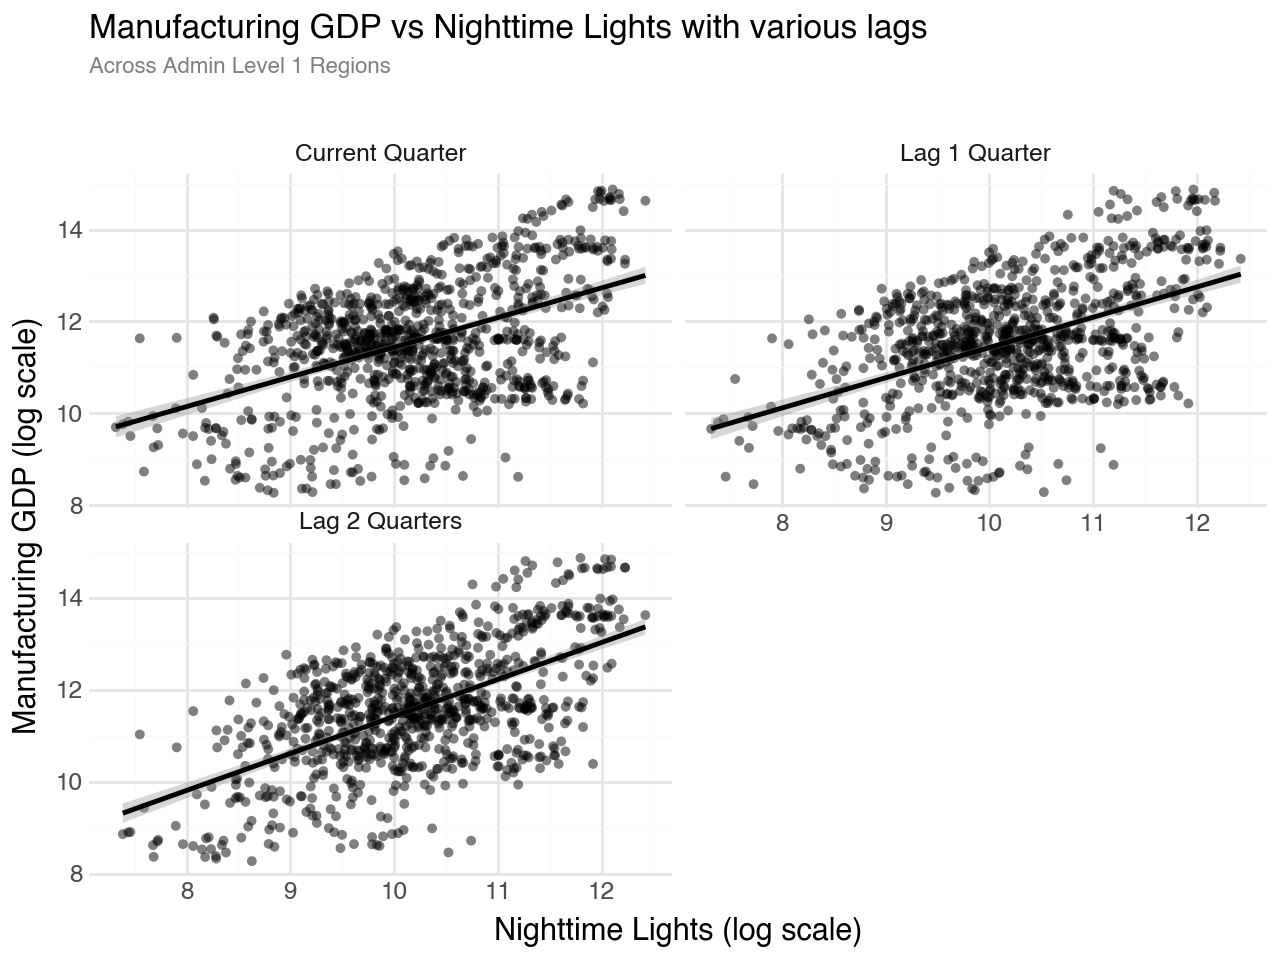

In [18]:
(
    ntl_indicators_adm1.filter(
        ["date", "gdp_log", "ntl_sum_log", "ntl_sum_lag_1_log", "ntl_sum_lag_2_log"]
    )
    .melt(id_vars=["gdp_log", "date"])
    .dropna(subset=["value"])
    .assign(
        variable=lambda df: df["variable"].replace(
            {
                "ntl_sum_log": "Current Quarter",
                "ntl_sum_lag_1_log": "Lag 1 Quarter",
                "ntl_sum_lag_2_log": "Lag 2 Quarters",
            }
        )
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="value", y="gdp_log")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.facet_wrap("variable", ncol=2)
    + p9.labs(
        title="Manufacturing GDP vs Nighttime Lights with various lags",
        subtitle="Across Admin Level 1 Regions",
        x="Nighttime Lights (log scale)",
        y="Manufacturing GDP (log scale)",
    )
    + p9.theme_minimal()
    + p9.theme(
        plot_title=p9.element_text(size=12, weight="bold"),
        plot_subtitle=p9.element_text(size=8, color="grey", margin={"b": 20}),
    )
)

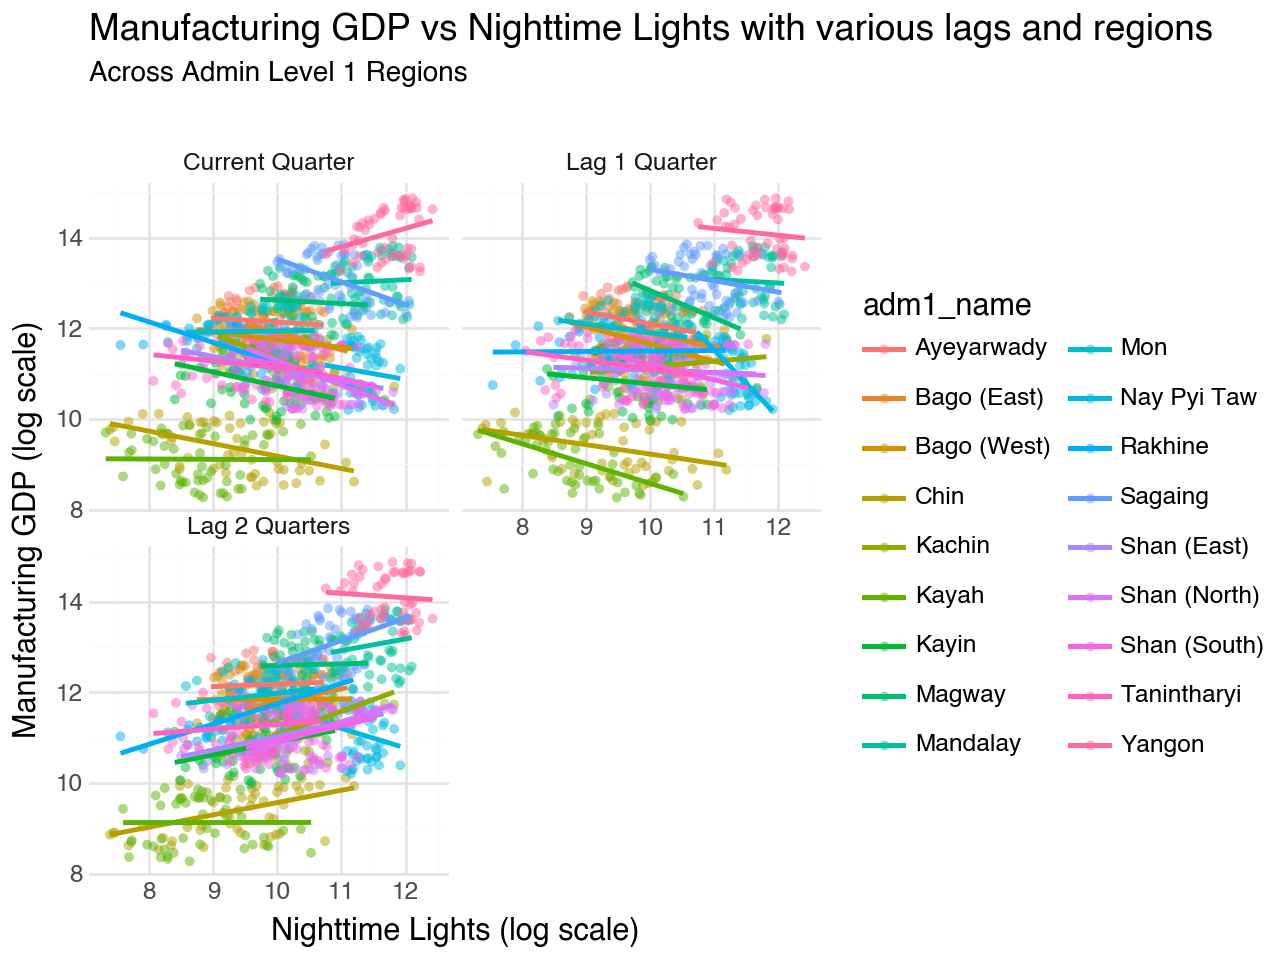

In [19]:
(
    ntl_indicators_adm1.filter(
        [
            "date",
            "adm1_name",
            "gdp_log",
            "ntl_sum_log",
            "ntl_sum_lag_1_log",
            "ntl_sum_lag_2_log",
        ]
    )
    .melt(id_vars=["gdp_log", "date", "adm1_name"])
    .dropna(subset=["value"])
    .assign(
        variable=lambda df: df["variable"].replace(
            {
                "ntl_sum_log": "Current Quarter",
                "ntl_sum_lag_1_log": "Lag 1 Quarter",
                "ntl_sum_lag_2_log": "Lag 2 Quarters",
            }
        )
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="value", y="gdp_log", color="adm1_name")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm", se=False)
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.facet_wrap("variable", ncol=2)
    + p9.labs(
        title="Manufacturing GDP vs Nighttime Lights with various lags and regions",
        subtitle="Across Admin Level 1 Regions",
        x="Nighttime Lights (log scale)",
        y="Manufacturing GDP (log scale)",
    )
    + p9.theme_minimal()
    + p9.theme(plot_subtitle=p9.element_text(margin={"b": 20}, size=10))
)

The chart by region below shows variation in the strength and pattern of the relationship between manufacturing GDP and nighttime lights across different regions. Major economic centers like Yangon exhibit clearer positive relationships, while some smaller states show more scattered patterns.

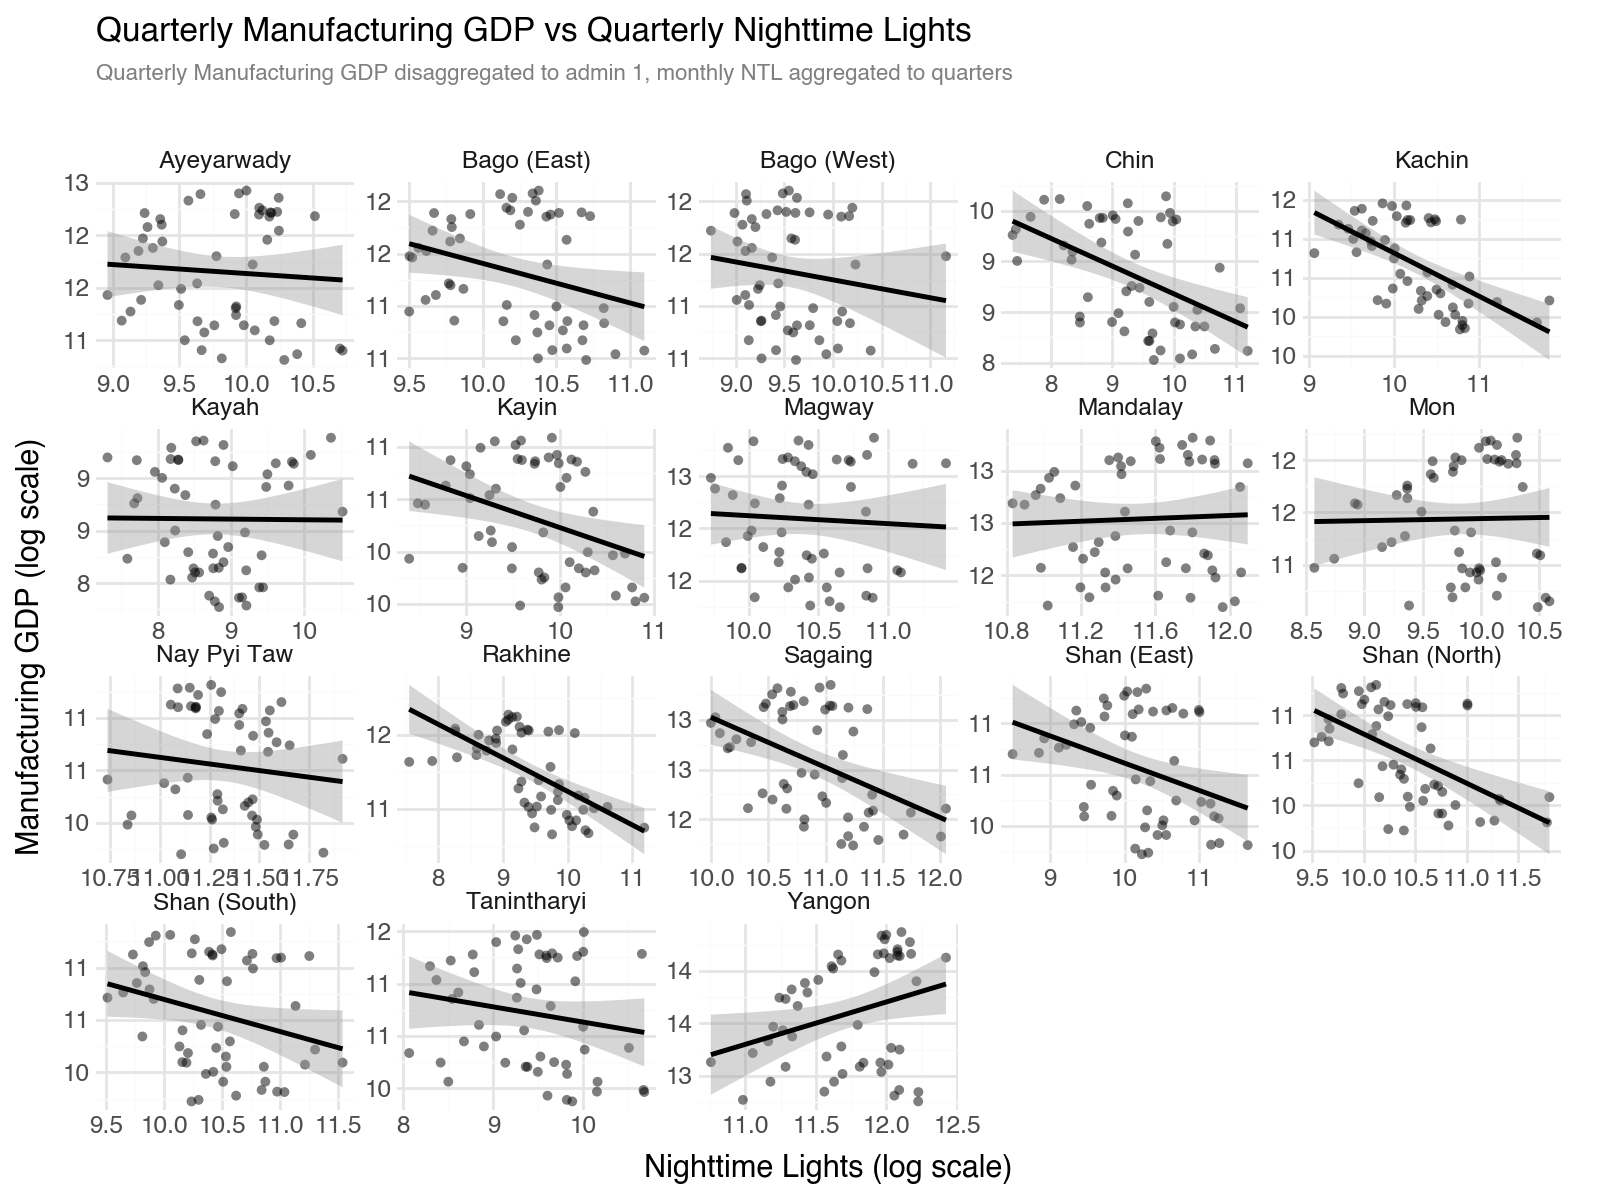

In [20]:
(
    ntl_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum_log", y="gdp_log")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.facet_wrap("adm1_name", scales="free")
    + p9.labs(
        title="Quarterly Manufacturing GDP vs Quarterly Nighttime Lights",
        subtitle="Quarterly Manufacturing GDP disaggregated to admin 1, monthly NTL aggregated to quarters",
        x="Nighttime Lights (log scale)",
        y="Manufacturing GDP (log scale)",
    )
    + p9.theme_minimal()
    + p9.theme(
        figure_size=(8, 6),
        plot_title=p9.element_text(size=12, weight="bold"),
        plot_subtitle=p9.element_text(size=8, color="grey", margin={"b": 20}),
    )
)

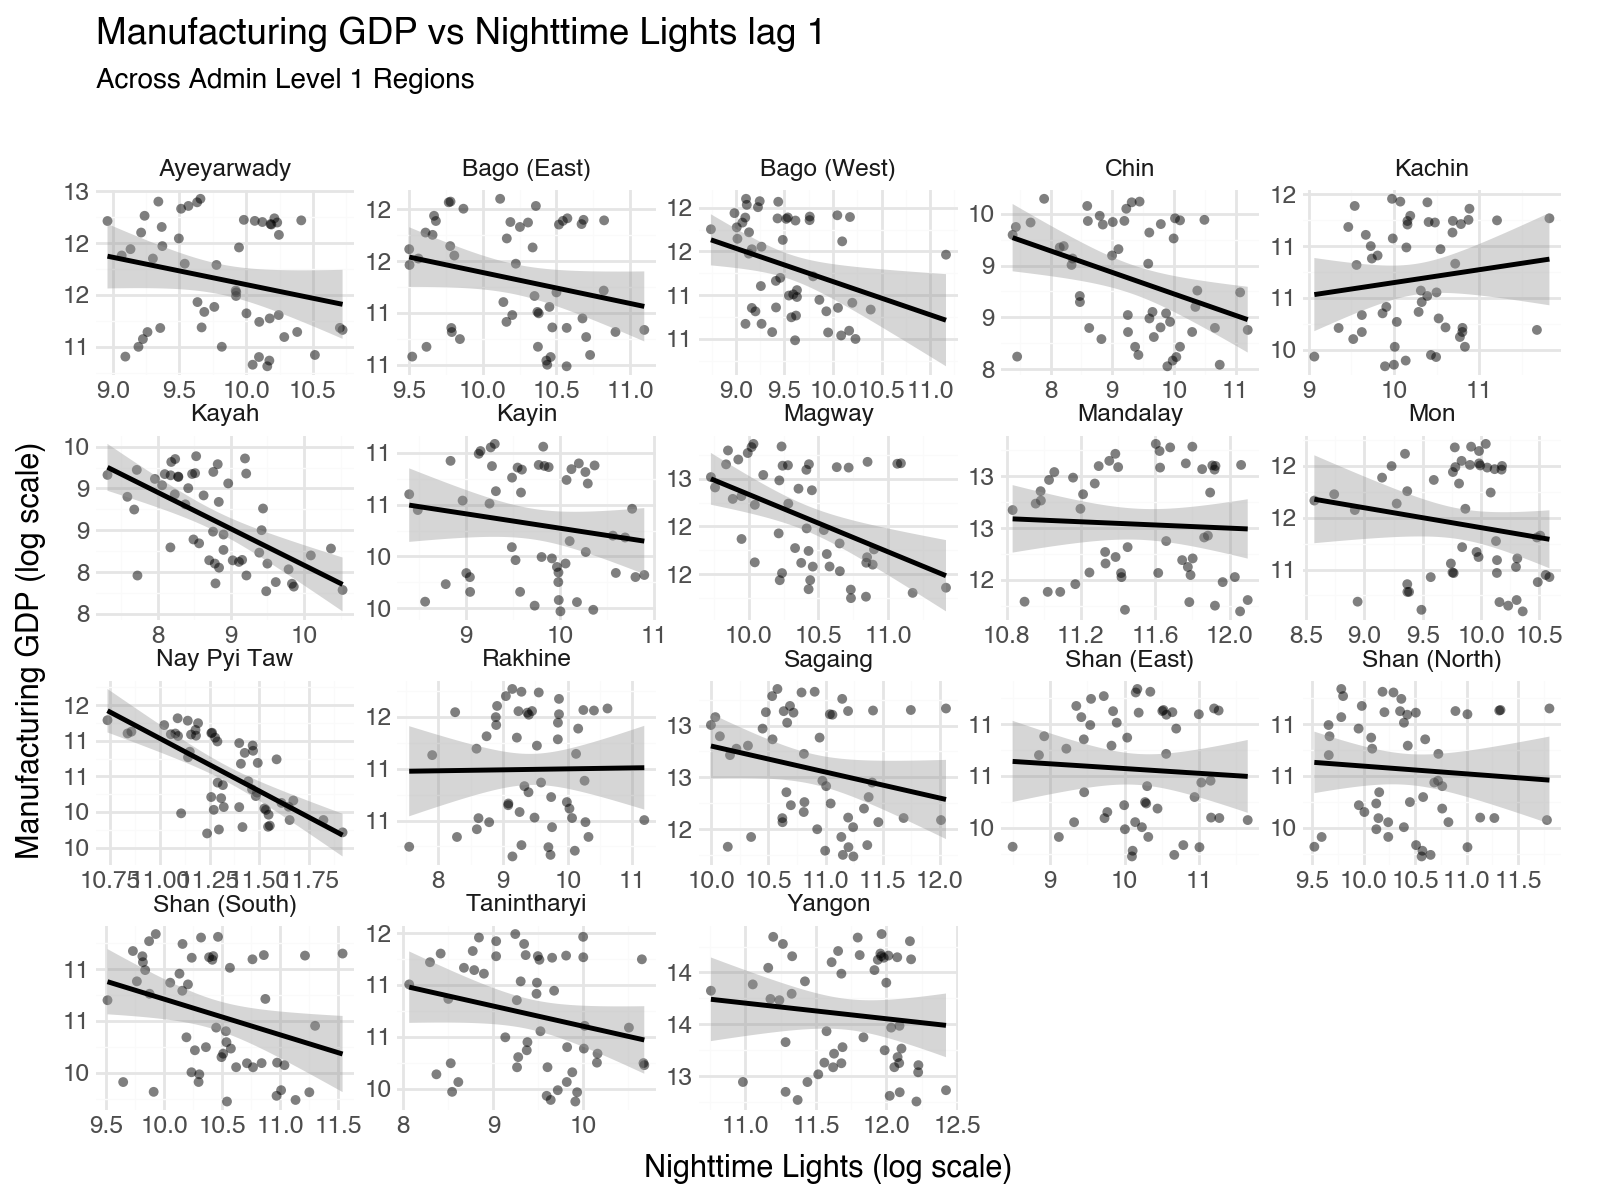

In [21]:
(
    ntl_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum_lag_1_log", y="gdp_log")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.facet_wrap("adm1_name", scales="free")
    + p9.labs(
        title="Manufacturing GDP vs Nighttime Lights lag 1",
        subtitle="Across Admin Level 1 Regions",
        x="Nighttime Lights (log scale)",
        y="Manufacturing GDP (log scale)",
    )
    + p9.theme_minimal()
    + p9.theme(
        figure_size=(8, 6), plot_subtitle=p9.element_text(margin={"b": 20}, size=10)
    )
)

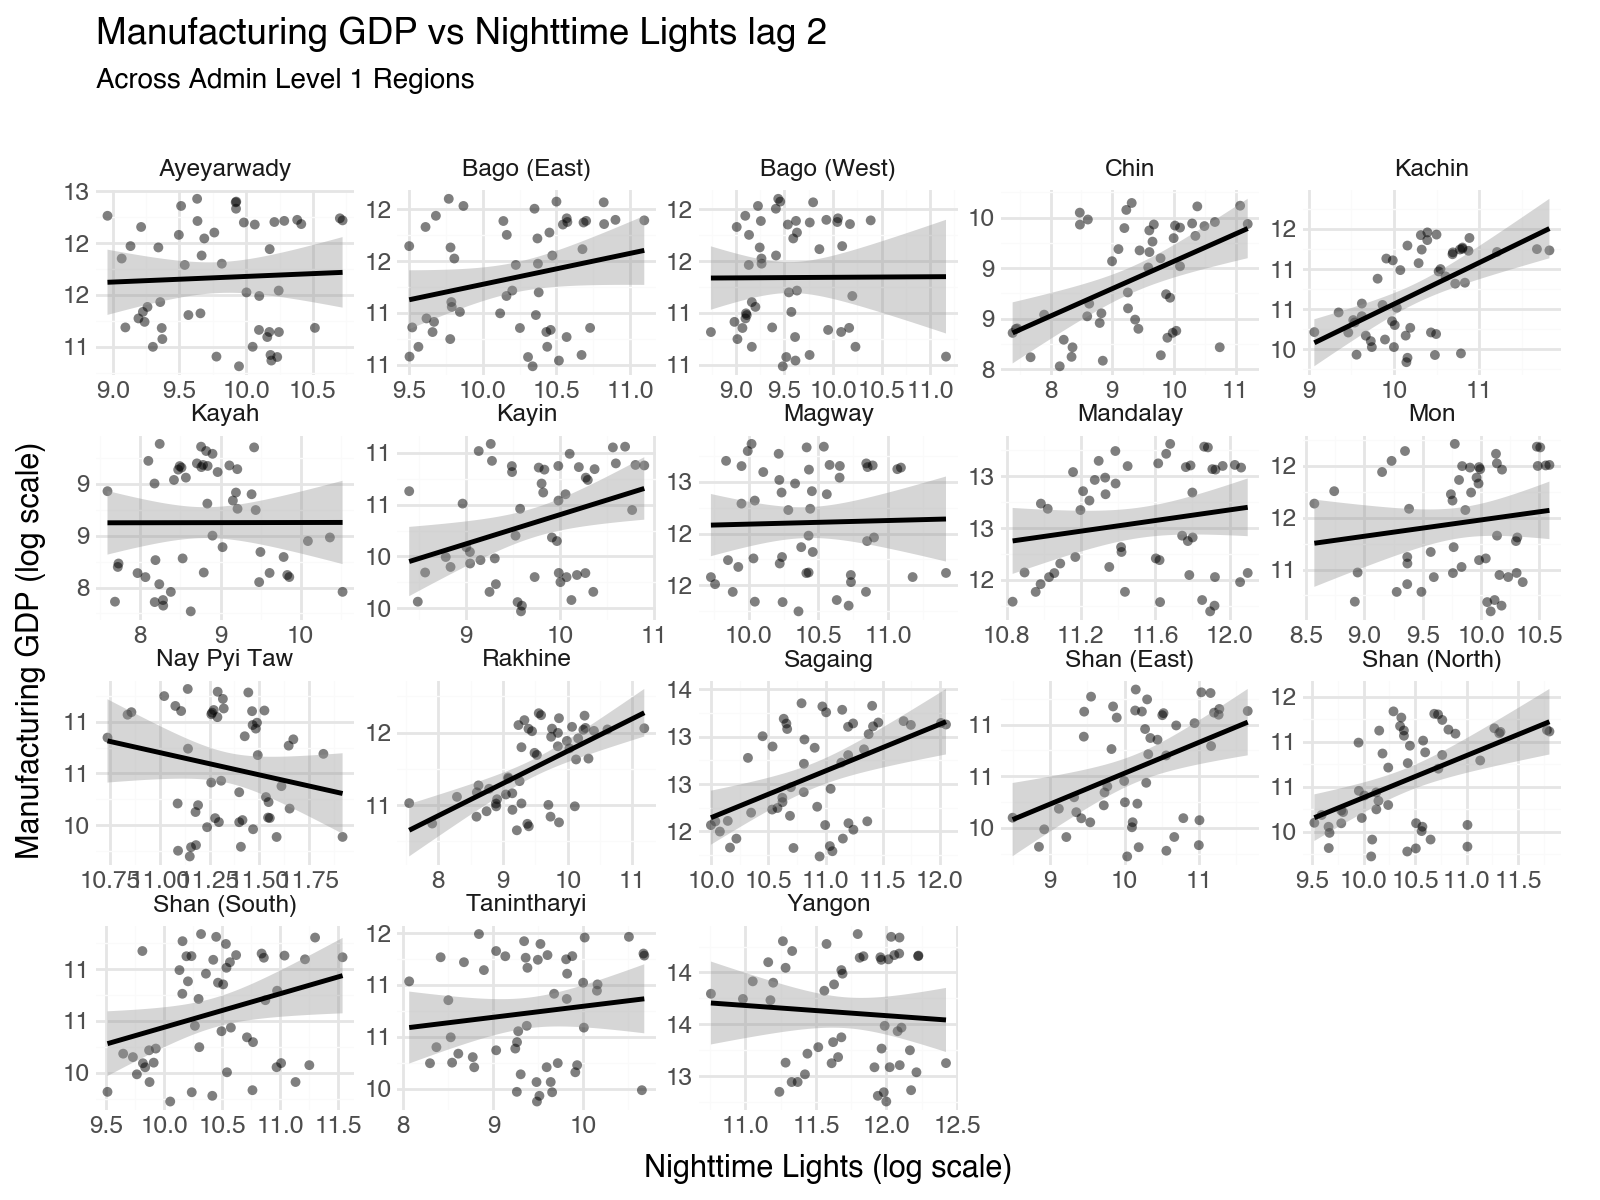

In [22]:
(
    ntl_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum_lag_2_log", y="gdp_log")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.facet_wrap("adm1_name", scales="free")
    + p9.labs(
        title="Manufacturing GDP vs Nighttime Lights lag 2",
        subtitle="Across Admin Level 1 Regions",
        x="Nighttime Lights (log scale)",
        y="Manufacturing GDP (log scale)",
    )
    + p9.theme_minimal()
    + p9.theme(
        figure_size=(8, 6), plot_subtitle=p9.element_text(margin={"b": 20}, size=10)
    )
)

The three regression models below provide different models in analyzing the regional relationship. Model 1 (pooled OLS) shows a basic positive relationship with a coefficient of 0.646. Model 2 adds region fixed effects, accounting for time-invariant regional characteristics, and shows a coefficient of -0.248 but improved explanatory power. Model 3 uses mixed effects to allow for both region-specific intercepts and slopes, providing the most nuanced view of regional heterogeneity.

In [23]:
mod_1 = smf.ols("gdp_log ~ ntl_sum_log", data=ntl_indicators_adm1).fit()
mod_2 = smf.ols(
    "gdp_log ~ ntl_sum_log + C(adm1_name)",
    data=ntl_indicators_adm1,
).fit()
mod_3 = smf.mixedlm(
    "gdp_log ~ ntl_sum_log",
    data=ntl_indicators_adm1.dropna(),
    groups=ntl_indicators_adm1.dropna()["adm1_name"],
    re_formula="~ntl_sum_log",
).fit()

models = Stargazer([mod_1, mod_2, mod_3])
models.custom_columns(
    [
        "Current only",
        "Current + Region FE",
        "Current + Mixed Effects",
    ],
    [1, 1, 1],
)
models.covariate_order(
    [
        "Intercept",
        "ntl_sum_log",
    ]
)
models

In [24]:
ntl_indicators_adm1_sez = (
    gdp_quarterly_adm1.join(ntl_quarterly_adm1_sez, how="inner")
    .reset_index()
    .sort_values(["adm1_name", "date"])
    .assign(
        gdp_log=lambda df: np.log(df["gdp"]),
        ntl_sum_log=lambda df: np.log1p(df["ntl_sum"]),
    )
)

When analyzing nighttime lights specifically from industrial zones at the regional level, the positive relationship with manufacturing GDP remains evident. The scatter plot shows a clear upward trend, indicating that industrial zone nighttime lights are a meaningful indicator of regional manufacturing activity.


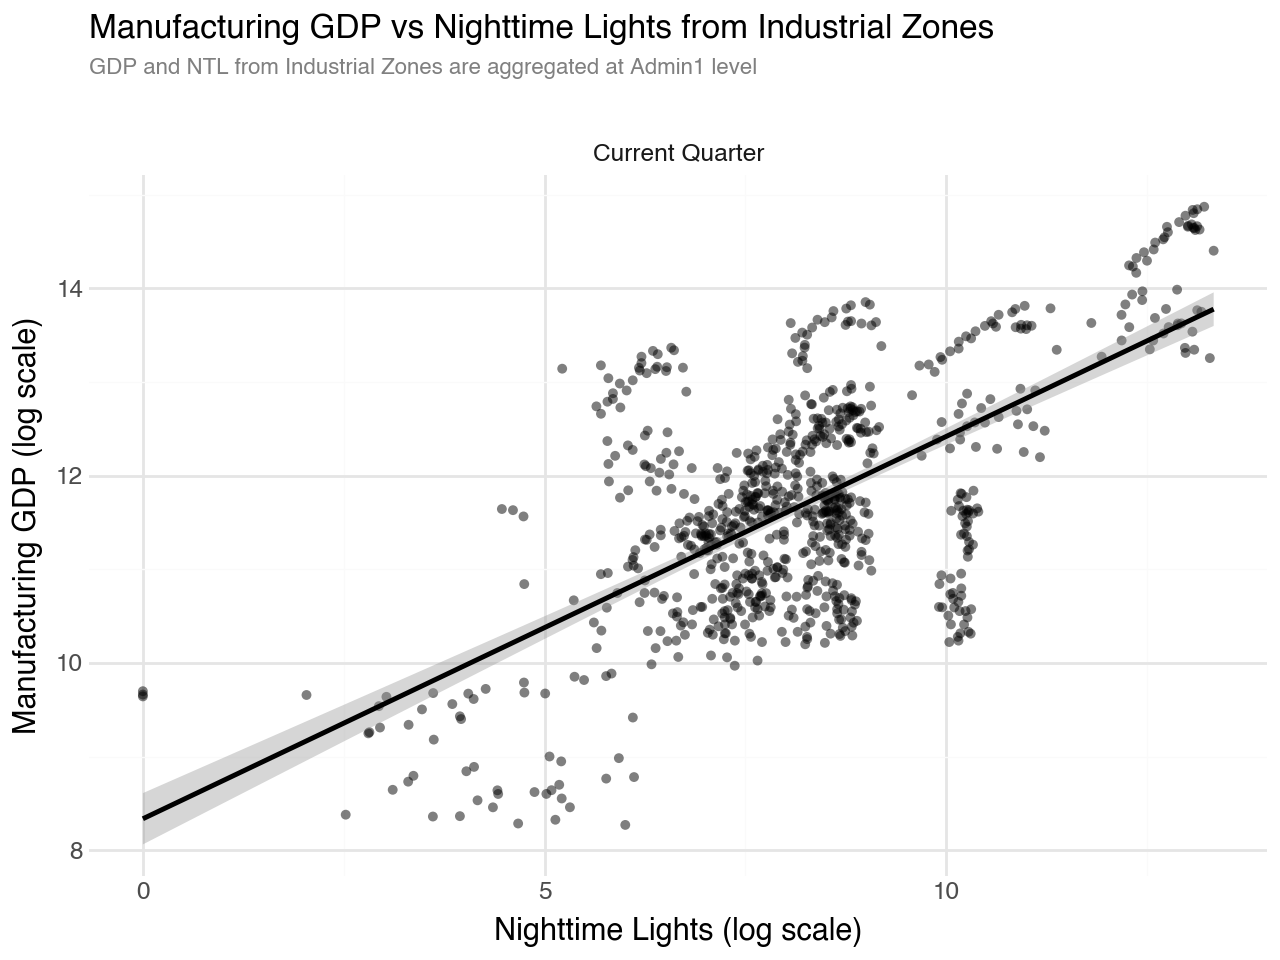

In [25]:
(
    ntl_indicators_adm1_sez.filter(["date", "gdp_log", "ntl_sum_log"])
    .melt(id_vars=["gdp_log", "date"])
    .dropna(subset=["value"])
    .assign(
        variable=lambda df: df["variable"].replace(
            {
                "ntl_sum_log": "Current Quarter",
            }
        )
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="value", y="gdp_log")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.facet_wrap("variable", ncol=2)
    + p9.labs(
        title="Manufacturing GDP vs Nighttime Lights from Industrial Zones",
        subtitle="GDP and NTL from Industrial Zones are aggregated at Admin1 level",
        x="Nighttime Lights (log scale)",
        y="Manufacturing GDP (log scale)",
    )
    + p9.theme_minimal()
    + p9.theme(
        plot_title=p9.element_text(size=12, weight="bold"),
        plot_subtitle=p9.element_text(size=8, color="grey", margin={"b": 20}),
    )
)

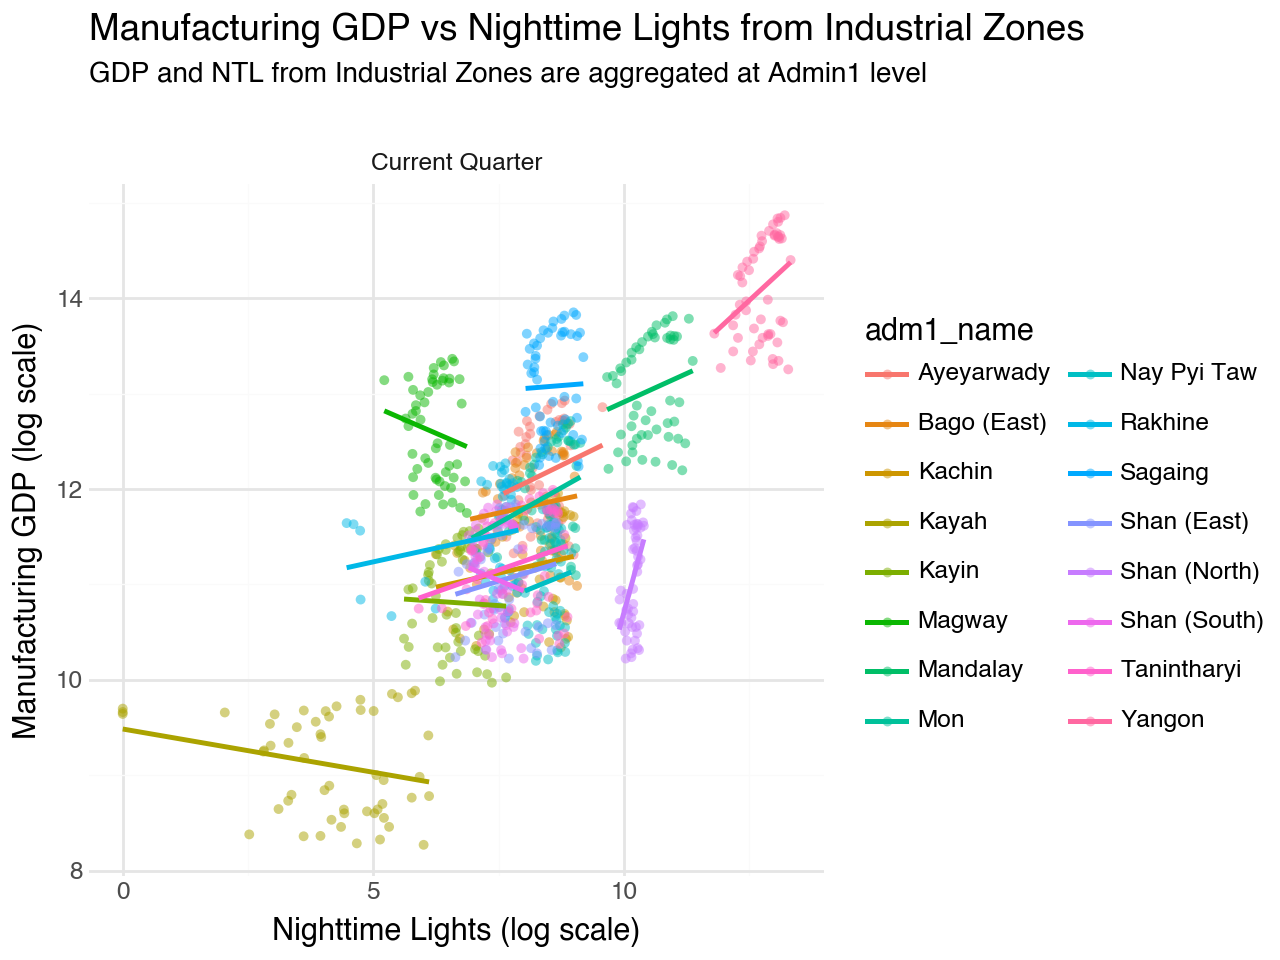

In [26]:
(
    ntl_indicators_adm1_sez.filter(
        [
            "date",
            "adm1_name",
            "gdp_log",
            "ntl_sum_log",
            "ntl_sum_lag_1_log",
            "ntl_sum_lag_2_log",
        ]
    )
    .melt(id_vars=["gdp_log", "date", "adm1_name"])
    .dropna(subset=["value"])
    .assign(
        variable=lambda df: df["variable"].replace(
            {
                "ntl_sum_log": "Current Quarter",
                "ntl_sum_lag_1_log": "Lag 1 Quarter",
                "ntl_sum_lag_2_log": "Lag 2 Quarters",
            }
        )
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="value", y="gdp_log", color="adm1_name")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm", se=False)
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.facet_wrap("variable", ncol=2)
    + p9.labs(
        title="Manufacturing GDP vs Nighttime Lights from Industrial Zones",
        subtitle="GDP and NTL from Industrial Zones are aggregated at Admin1 level",
        x="Nighttime Lights (log scale)",
        y="Manufacturing GDP (log scale)",
    )
    + p9.theme_minimal()
    + p9.theme(plot_subtitle=p9.element_text(margin={"b": 20}, size=10))
)

The regional breakdown of industrial zone nighttime lights versus manufacturing GDP reveals significant variation across states/regions. Some regions like Yangon show tight relationships with steep slopes, while others display more scattered patterns. This heterogeneity underscores the importance of region-specific analysis when using nighttime lights as an economic indicator, as the relationship's strength varies with local industrial structure and development levels.

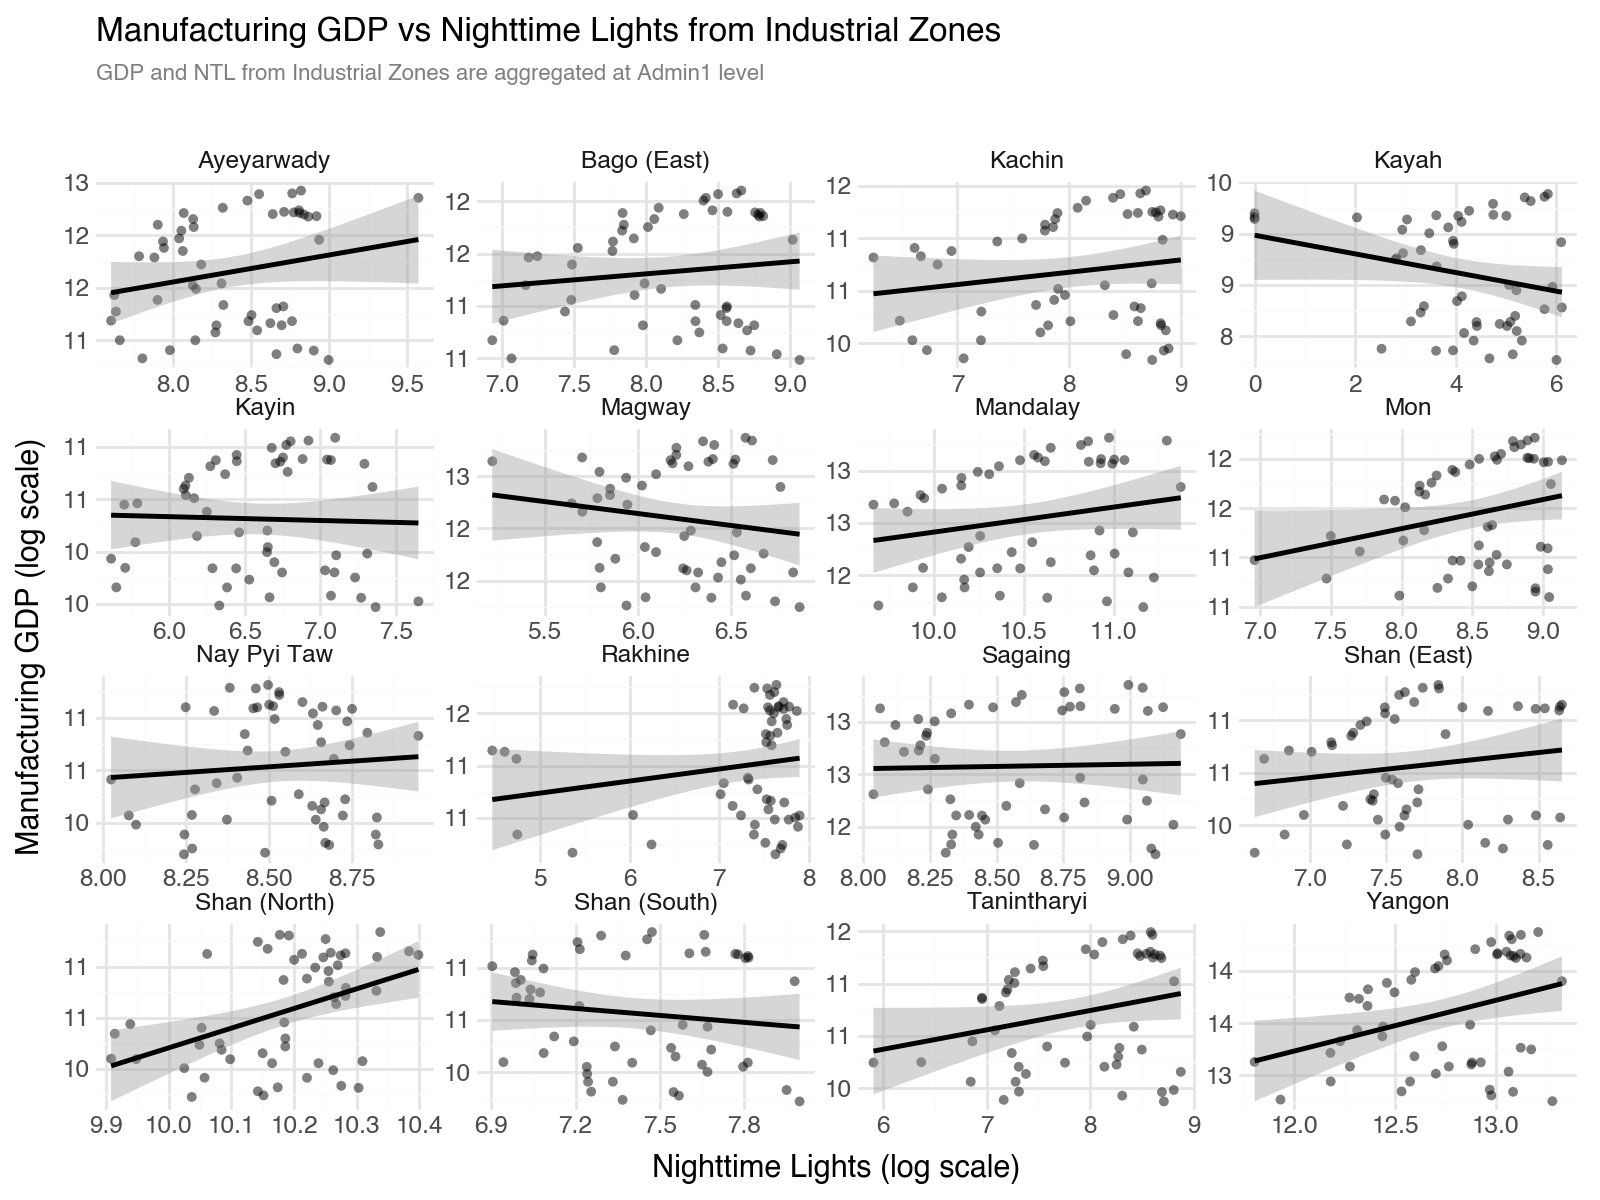

In [27]:
(
    ntl_indicators_adm1_sez.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum_log", y="gdp_log")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.facet_wrap("adm1_name", scales="free")
    + p9.labs(
        title="Manufacturing GDP vs Nighttime Lights from Industrial Zones",
        subtitle="GDP and NTL from Industrial Zones are aggregated at Admin1 level",
        x="Nighttime Lights (log scale)",
        y="Manufacturing GDP (log scale)",
    )
    + p9.theme_minimal()
    + p9.theme(
        figure_size=(8, 6),
        plot_title=p9.element_text(size=12, weight="bold"),
        plot_subtitle=p9.element_text(size=8, color="grey", margin={"b": 20}),
    )
)

The regression analysis using industrial zone nighttime lights at the regional level shows strong results across all three model specifications. The pooled OLS model (Model 1) yields a coefficient of 0.403, while the fixed effects model (Model 2) shows a lower coefficient of 0.060. The mixed effects model (Model 3) provides the most sophisticated specification, allowing for region-specific variations shows a coefficient of 0.079. All models are statistically significant, demonstrating that nighttime lights from industrial zones are robust predictors of regional manufacturing GDP.

In [28]:
mod_1 = smf.ols("gdp_log ~ ntl_sum_log", data=ntl_indicators_adm1_sez).fit()
mod_2 = smf.ols(
    "gdp_log ~ ntl_sum_log + C(adm1_name)",
    data=ntl_indicators_adm1_sez,
).fit()
mod_3 = smf.mixedlm(
    "gdp_log ~ ntl_sum_log",
    data=ntl_indicators_adm1_sez.dropna(),
    groups=ntl_indicators_adm1_sez.dropna()["adm1_name"],
    re_formula="~ntl_sum_log",
).fit()

models = Stargazer([mod_1, mod_2, mod_3])
models.custom_columns(
    [
        "Current only",
        "Current + Region FE",
        "Current + Mixed Effects",
    ],
    [1, 1, 1],
)
models.covariate_order(
    [
        "Intercept",
        "ntl_sum_log",
    ]
)
models